### <p style="text-align: center;">Neural Tangent Kernel</p> 
#### <p style="text-align: center;">How do neural network learn and generalise well?</p> 

**Neural Tangent Kernel (NTK)** is a kernel that describes the training dynamics of a neural network, allowing one to study the learning process and generalisation features of the network.

In this code, we will study **Neural Networks with non-Gaussian Initialisation** through NTK with the following results:

1. **The limiting NTK**, that is the deterministic NTK in the infinite width limit of neural network, **can be derived recursively for non-Gaussian initialisation**.
2. **The limiting NTK does not depend on the choice of weight distributions in the hidden layers**, given the initial distribution for bias parameters in the hidden layers is Gaussian.
3. **The limiting NTK approximates the finite-width neural network**, and as a result, it is possible to approximate the result of a trained neural network with non-Gaussian initialisation.

In [1]:
import numpy as np

import torch
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal

import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import norm

import itertools

##### Neural Network

Fixed $D\in\mathbb{N}$ and $n_0, ..., n_{D+1}\in\mathbb{N}$. Let $f({\theta}; x):\mathbb{R}^{P}\times\mathbb{R}^{n_{in}}\to\mathbb{R}^{n_{out}}$ be the network function, where the function $f({\theta}; x):=z^{(D+1)}({\theta}; x)$ is defined recursively by
\begin{equation*}
\begin{split}
z^{(1)}\left({\theta^{(\leq 1)}}; x\right)&=\frac{\sigma_w}{\sqrt{n_0}}W^{(1)}x+\sigma_b b^{(1)},\\
x^{(i)}\left({\theta^{(\leq i)}}; x\right)&=\phi\left[z^{(i)}\left({\theta^{(\leq i)}}; x\right)\right],\\
z^{(i+1)}\left({\theta^{(\leq i+1)}}; x\right)&=\frac{\sigma_w}{\sqrt{n_i}}W^{(i+1)}x^{(i)}\left({\theta^{(\leq i)}}; x\right)+\sigma_b b^{(i+1)},\\
\end{split}
\end{equation*}
for $i=1, ..., D$, where

$z^{(i)}$: preactivation in the $i$-th layer, <br>
$x^{(i)}$: activation in the $i$-th layer, <br>
$\phi$: activation function, <br>
$\sigma_w$: standard deviation of weight parameters, <br>
$\sigma_b$: standard deviation of bias parameters, <br>
$W^{(i+1)}$: weight that connects layer $i$ to $i+1$, <br>
$b^{(i+1)}$: bias that connects layer $i$ to $i+1$, <br>
$\theta^{(\leq i)}$: vector of trainable parameters to layer $i$. <br>

**Note:** This network parameterisation is known as NTK parameterisation. By adjusting the learning rates, it is possible to derive the same dynamic with the standard parameterisation (where the $\sigma_w$ and $\sigma_b$ are part of the distributions).

###### Parameter Distribution

Given the network function $f$, defined with $D\in\mathbb{N}$ hidden layers and $n_0, ..., n_{D+1}\in\mathbb{N}$ neurons. With $P$ representing the number of parameters in the network, the parameter $\theta\in\mathbb{R}^{P}$ is initialised with


$\theta^{(1)}_1, ..., \theta^{(1)}_{P_{W^{(1)}}}\sim\mu_W$ i.i.d. (Distribution of first layer weight parameters), \
$\theta^{(1)}_{P_{W^{(1)}}+1}, ..., \theta^{(1)}_{P_{\theta^{(1)}}}\sim\mu_b$ i.i.d. (Distribution of first layer bias parameters), \
$\theta^{(i+1)}_1, ..., \theta^{(i+1)}_{P_{W^{(i+1)}}}\sim\mu^{(i+1)}$ i.i.d. (Distribution of other layers weight parameters), \
$\theta^{(i+1)}_{P_{W^{(i+1)}}}, ..., \theta^{(i+1)}_{P_{\theta^{(i+1)}}}\sim\mathcal{N}\left(0,1\right)$ i.i.d.  (Distribution of other layers bias parameters), \
$\theta_1, ..., \theta_P$ are independent(Independence of all parameters),


for $i=1, ..., D$, where $P_{W^{(i+1)}}$ and ${P_{\theta^{(i+1)}}}$ denote the number of weight parameters and the number of parameters in the $i+1$-th layer, respectively. The distributions $\mu^{(2)}, ..., \mu^{(D+1)} \mu_W,$ and $\mu_b$ belong to the set of probability measures $\mathcal{P}$ on $\mathcal{B}(\mathbb{R})$, which are absolutely continuous with respect to Lebesgue measure with density $g$ that satisfies

$\forall n>0$, $\int_{-\infty}^{\infty} \lvert x \rvert^n g(x) \,dx <\infty$ (All moments exist), \
$\int_{-\infty}^{\infty} xg(x) \,dx = 0$ (Zero mean), \
$\int_{-\infty}^{\infty} x^2g(x) \,dx = 1$ (Unit variance).


In [2]:
def _no_grad_laplace_(tensor, mean, std):
    with torch.no_grad():
        return torch.distributions.laplace.Laplace(mean, std/np.sqrt(2), validate_args=None).sample(tensor.shape)
    
def _no_grad_normal_(tensor, mean, std):
    with torch.no_grad():
        return torch.distributions.normal.Normal(mean, std, validate_args=None).sample(tensor.shape)
    
def _no_grad_uniform_(tensor, mean, std):
    with torch.no_grad():
        return torch.distributions.uniform.Uniform(low=mean-np.sqrt(3)*std, high=mean+np.sqrt(3)*std, validate_args=None).sample(tensor.shape)

def _no_grad_gumbel_(tensor, mean, std):
    with torch.no_grad():
        scale = (np.sqrt(6)*std/np.pi)
        return torch.distributions.gumbel.Gumbel(loc=mean-scale*np.euler_gamma, scale=scale, validate_args=None).sample(tensor.shape)
    
def _no_grad_categorical_(tensor, mean, std):
    with torch.no_grad():
        b = 3
        a = -1/b
        p = 1/(b**2+1)
        r = b-a
        return a+r*torch.distributions.bernoulli.Bernoulli(probs=p, validate_args=None).sample(tensor.shape)
    
f_dist = {'laplace' : _no_grad_laplace_,
          'normal' : _no_grad_normal_,
          'uniform' : _no_grad_uniform_,
          'gumbel' : _no_grad_gumbel_,
          'categorical' : _no_grad_categorical_}

###### Linear Layer

In [3]:
class custom_linear(nn.Module):
    '''
    Define a linear layer with NTK parameterisation
    
    Input:
    n_input : (int) size of input
    n_output: (int) size of output
    bias: (boolean) indicator to use bias or not
    sigma: (list) weight and bias standard deviation
    dist_w: (str) distribution of weight
    dist_b: (str) distribution of bias
    '''
    
    def __init__(self, n_input, n_output, bias, sigma, dist_w, dist_b):
        super(custom_linear, self).__init__()
        self.n_input, self.n_output = n_input, n_output
        self.W = torch.Tensor(n_input, n_output)
        self.bias = bias
        self.dist_w = dist_w
        self.dist_b = dist_b
        
        # define weight and bias 
        self.W = nn.Parameter(f_dist[dist_w](self.W, 0, 1))
        if bias:
            self.b = torch.Tensor(n_output)
            self.b = nn.Parameter(f_dist[dist_b](self.b, 0, 1))
    
    def reset_parameters(self):
        # simplification to reset model parameters
        self.W = nn.Parameter(f_dist[self.dist_w](self.W, 0, 1))
        if self.bias:
            self.b = nn.Parameter(f_dist[self.dist_b](self.b, 0, 1))
            
    def forward(self, x):
        # forward proporgation
        mul_x = (sigma[0]/np.sqrt(self.n_input))*torch.mm(x, self.W)
        if self.bias:
            out_x = torch.add(mul_x, sigma[1]*self.b)
        else:
            out_x = mul_x
        return out_x
    
def weight_reset(layer):
    '''
    Reset the parameters of the given neural network's layer
    
    Input:
    layer: layer of the neural network
    '''
    if isinstance(layer, custom_linear):
        layer.reset_parameters()
        

###### Activation Function

In [4]:
class erf(nn.Module):
    '''
    Define an erf activation function
    '''
    def __init__(self):
        super(erf, self).__init__()

    def forward(self, x):
        return torch.erf(x)
    
f_act = {'relu' : nn.ReLU(),
         'erf' : erf()}

###### Main Network

In [5]:
class simple_nn(nn.Module):
    '''
    Define a simple neural network with NTK parameterisation
    
    Input:
    n_input: (int) size of input
    n_output: (int) size of output
    width: (int) number of neurons in each layer
    activation: (str) the choice of activation function
    n_hidden: (int) number of hidden layers
    bias: (boolean) indicator to use bias or not
    sigma: (list) weight and bias standard deviation
    dist_w: (list) distribution of weight
    dist_b: (list) distribution of bias
    '''
    def __init__(self, n_input, n_output, width, activation, bias, n_hidden, sigma, dist_w, dist_b):
        super(simple_nn, self).__init__()
        # Set important parameters
        self.n_hidden = n_hidden
        self.activation = activation
        self.sigma = sigma
        self.bias = bias
        self.n_input, self.n_output = n_input, n_output
        self.dist_w = dist_w
        self.dist_b = dist_b
        
        if n_hidden != 0:
            # Define first hidden layer 
            input_ = [custom_linear(n_input, width, bias=bias, sigma=sigma, dist_w=dist_w[0], dist_b=dist_b[0]),
                      f_act[activation]]

            # Define the rest of hidden layers
            hidden_ = [custom_linear(width, width, bias=bias, sigma=sigma, dist_w=dist_w[1], dist_b=dist_b[1]),
                      f_act[activation]]*(n_hidden-1)

            # Define readout layer
            output_ = [custom_linear(width, n_output, bias=bias, sigma=sigma, dist_w=dist_w[1], dist_b=dist_b[1])]
        
        else:
            input_ = []
            hidden_ = []
            output_ = [custom_linear(n_input, n_output, bias=bias, sigma=sigma, dist_w=dist_w[0], dist_b=dist_b[0])]
        
        # Connect the all of the layers
        self.network = nn.Sequential(*(input_+hidden_+output_))
        
    def forward(self, x):
        # forward proporgation
        return self.network(x)
    
def layer_f(f, x, preactivation):
    '''
    Obtain the outputs of the preactivation from a given input
    
    Input:
    
    f: a neural network defined from simple_nn
    x: (tensor) network's input
    preactivation: (int) the order of preactivation that will be returned
    '''
    
    # case for the first preactivation
    if preactivation==1:
        return np.array(f.network[0](x).detach())
    else:
        temp = f.network[0](x)
        for i in range(preactivation-1):
            temp = f.network[2*i+1](temp)
            temp = f.network[2*(i+1)](temp)
            
        return np.array(temp.detach())

##### Loss Function

Let $l(\hat y, y):\mathbb{R}^{n_{out}}\times\mathbb{R}^{n_{out}}\to\mathbb{R}$ be the loss function and define the total loss function $\mathcal{L}\left(\theta; \mathcal{X}, \mathcal{Y}\right)=\sum_{\left(x\in\mathcal{X}, y\in\mathcal{Y}\right)} l\left(f(\theta;x), y\right)\in\mathbb{R}$. Our aim in the prediction task is to find $\theta$ that minimises the total loss function $\mathcal{L}\left(\theta; \mathcal{X}, \mathcal{Y}\right)$ by using an optimisation method.

By abusing notation, we can see $\mathcal{L}$ as a function of predicted values and its corresponding labels, $\mathcal{L}\left(f\left(\theta; \mathcal{X}\right), \mathcal{Y}\right)$.

In this code, we consider a variation of MSE **loss function**, $l(\hat y, y)$, defined by

\begin{equation*}
    l(\hat y, y)=\frac{1}{2}\|\hat y-y\|^2_2.
\end{equation*}

The fraction $\frac{1}{2}$ is used for MSE instead of using the number of observation, $\frac{1}{|\mathcal{D}|}$, to produce a simpler form of the solution.

##### Gradient Descent

Consider the network function $f\left(\theta_t; \mathcal{X}\right)$  with a time-dependent parameter $\theta_t$ initialised with $\theta_0\in\mathbb{R}^P$. The continuous-time gradient descent is described by the following dynamics:

\begin{equation*}
    \begin{split}
        \partial_t \theta_t&=-\eta\nabla_\theta\mathcal{L}\left(\theta_t; \mathcal{X}, \mathcal{Y}\right)\\
        &=-\eta\nabla_\theta f(\theta_t; \mathcal{X})^T\nabla_{f\left(\theta; \mathcal{X}\right)}\mathcal{L}\left(f\left(\theta_t; \mathcal{X}\right), \mathcal{Y}\right),
    \end{split}
\end{equation*}

for $t>0$, where $\nabla_\theta f(\theta; \mathcal{X})\in\mathbb{R}^{|\mathcal{D}|n_{out}\times P}$, $\nabla_{f\left(\theta; \mathcal{X}\right)}\mathcal{L}\left(f\left(\theta; \mathcal{X}\right), \mathcal{Y}\right)\in\mathbb{R}^{|\mathcal{D}|n_{out}\times 1}$, and $\eta>0$ is the learning rate. By contrast, the discrete-time gradient descent is defined for $t=0, 1, ...,$ by
\begin{equation*}
    \begin{split}
        \theta_{t+1}-\theta_t&=-\eta\nabla_\theta\mathcal{L}\left(\theta_t; \mathcal{X}, \mathcal{Y}\right)\\
        &=-\eta\nabla_\theta f(\theta_t; \mathcal{X})^T\nabla_{f\left(\theta; \mathcal{X}\right)}\mathcal{L}\left(f\left(\theta_t; \mathcal{X}\right), \mathcal{Y}\right).
    \end{split}
\end{equation*}

The interpretation of gradient descent is that $\theta_t$ evolves in the direction that minimises $\mathcal{L}$; that direction is $\nabla_\theta \mathcal{L},$ while $\eta$ acts as the speed in that direction.

In [6]:
class simple_mse_loss(nn.Module):
    '''
    Define a customise mse loss
    '''
    def __init__(self):
        super(simple_mse_loss, self).__init__()
        
    def forward(self, y_hat, y):
        loss = (y-y_hat)**2
        # 1/2 is used instead 1/n to get a simpler form.
        loss = 1/2*loss.sum()
        return loss
    
loss_mse = simple_mse_loss()

def train_f(f, loss_f, X_train, Y_train, t, lr):
    '''
    A function to update parameters in a function according to a loss function through Gradient Descent
    
    Input:
    f : (class) function of x->y
    loss_f : (function) loss function
    X_train : (tensor) a set of training examples
    Y_train : (tensor) a set of label for training examples
    t : (int) number of iteration
    lr : (float) learning rate
    '''
    optimiser = torch.optim.SGD(f.parameters(), lr=lr)
    for _ in range(t):
        optimiser.zero_grad()
        loss = loss_f(f(X_train), Y_train)
        loss.backward()
        optimiser.step()    

#### NNGP
Under the infinite width limit, the preactivations, except the first preactivation, at initialisation are Gaussian processes described by deterministic kernels even if the initial distribution for the parameters is not Gaussian. The deterministic kernels are known as **the Neural Network Gaussian Process (NNGP) Kernels.**

#### Limiting NNGP Kernel

Consider the network function $f$, defined with $D\in\mathbb{N}$ hidden layers and $n_0, ..., n_{D+1}\in\mathbb{N}$ neurons. The network is initialised with weight distributions from $\mathcal{P}$ and configuration for weight and bias parameters at initialisation described above. In addition, the activation function $\phi$ satisfy absolutely continuous and polynomially bounded conditions. The $j$-th element of the preactivation $z^{(i+1)}_j\left(\theta^{(\leq i+1)}; x\right)=z^{(i+1)}_j\left(x\right)$, conditioned on the value of $x$, converges in distribution to a centred Gaussian process with kernel function $\tilde K^{(i+1)}(x, x'):\mathbb{R}^{n_{in}}\times\mathbb{R}^{n_{in}}\to\mathbb{R}$ as the numbers of neurons in the previously hidden layers $n_1, ..., n_{i}\to\infty$ sequentially, where $\tilde K^{(i+1)}(x, x')$ is defined recursively by
    \begin{equation*}
        \begin{split}
            \tilde K^{(n+1)}(x, x') &= \sigma_w^2\mathbb{E}_{(u, v)
            \sim\mathcal{N}\left(0, K^{(n)}(x, x')\right)}\left[\phi(u)\phi(v)\right]+\sigma_b^2,\\
            K^{(n)}(x, x') &= 
            \begin{bmatrix}\tilde K^{(n)}(x, x)&\tilde K^{(n)}(x, x')\\\tilde K^{(n)}(x', x)&\tilde K^{(n)}(x', x'),\end{bmatrix},
        \end{split}
    \end{equation*}
for $n=2, ..., i$ and $x, x' \in\mathbb{R}^{n_{in}}$, where $\tilde K^{(2)}(x, x')$ is initialised as
    \begin{equation*}
        \begin{split}
            \tilde K^{(2)}(x, x') &= \sigma_w^2\mathbb{E}_{(u, v)
            \sim\nu(x, x')}\left[\phi(u)\phi(v)\right]+\sigma_b^2,\\
        \end{split}
    \end{equation*}
and $\nu(x, x')$ denotes the joint distribution of $z^{(1)}_1(x)$ and $z^{(1)}_1(x')$.

#### NTK

The neural tangent kernel at time $t$ of a network function $f\left(\theta; x\right)$ can be defined with a time-dependent kernel $\Theta_t:\mathbb{R}^{n_{in}\times n_{in}}\to\mathbb{R}^{n_{out}\times n_{out}}$ defined as

\begin{equation*}
    \Theta_t\left(x, x'\right)=\nabla_\theta f(\theta_t; x)\nabla_\theta f(\theta_t; x')^T
\end{equation*}


The definition of NTK can be further generalised to take input from any input sets by abusing the notation, e.g., $\Theta_t\left(\mathcal{X}, \mathcal{X}_{test}\right)=\nabla_\theta f(\theta_t; \mathcal{X})\nabla_\theta f(\theta_t; \mathcal{X}_{test})^T$.

Let $f\left(\theta; x\right)$ be a network function defined. The linearised network of $f$ is defined as

#### Linearised Network

\begin{equation*}
    f^{lin}(\theta_t; x)=f(\theta_0; x)+\nabla_\theta f(\theta_0; x)(\theta_t-\theta_0).
\end{equation*}

With a given $\mathcal{L}$, the dynamics of $\theta_t$ and $f^{lin}(\theta_t; x)$ are derived as follows

\begin{equation*}
    \begin{split}
        \partial_t\theta_t &= -\eta\nabla_\theta f(\theta_0; \mathcal{X})^T\nabla_{f(\theta; \mathcal{X})}\mathcal{L}(f^{lin}(\theta_t; \mathcal{X}), \mathcal{Y}),\\
        \partial_t f^{lin}(\theta_t; x) &= -\eta\Theta_0(x, \mathcal{X})\nabla_{f(\theta; \mathcal{X})}\mathcal{L}(f^{lin}(\theta_t; \mathcal{X}), \mathcal{Y}).
    \end{split}
\end{equation*}

As can be seen, the dynamic of $f^{lin}$ can be described by a deterministic NTK at initialisation, and it remains constant during gradient descent training. Surprisingly, the linearised network **$f^{lin}(\theta_t; x)$ has the same distributions as the actual network $f(\theta_t; x)$ in the infinite width limit**.

#### Limiting NTK

Consider a fully-connected neural network with $D$ hidden layers, each having $n_i$ neurons for $i=1, ..., D$. The network is initialised with weight distributions from $\mathcal{P}$ and configuration for weight and bias parameters at initialisation defined above. In addition, the activation function $\phi$ satisfies absolutely continuous with derivative defined almost everywhere with the polynomially bounded condition. As the numbers of neurons in hidden layers $n_1, ..., n_D\to\infty$ sequentially, $\Theta_t(x, x')$ converges in probability to a deterministic kernel $\Theta^{(D+1)}(x, x') = \tilde \Theta^{(D+1)}(x, x')I_{n_{out}}$, where $\tilde \Theta^{(D)}(x, x')$ can be defined recursively by

\begin{equation*}
    \tilde \Theta^{(i+1)}(x, x')=\tilde K^{(i+1)}(x, x')+\sigma_w^2\tilde \Theta^{(i)}(x, x')\mathbb{E}_{(u, v)\sim\mathcal{N}\left(0, K^{(i)}(x, x')\right)}\left[\left(\phi\right)'(u)\left(\phi\right)'(v)\right],
\end{equation*}

for $i=2, ..., D$ with $\Theta^{(2)}(x, x')$ and $\Theta^{(1)}(x, x')$ are initialised with

\begin{equation*}
    \begin{split}
        \tilde \Theta^{(2)}(x, x') &= \tilde K^{(2)}(x, x')+\sigma_w^2\tilde\Theta^{(1)}(x, x')\mathbb{E}_{(u, v)
            \sim\nu(x, x')}\left[\left(\phi\right)'\left(u\right)\left(\phi\right)'\left(v\right)\right],\\
        \tilde \Theta^{(1)}(x, x') &= \frac{\sigma_w^2}{n_0}x^Tx'+\sigma_b^2,
    \end{split}
\end{equation*}

where $\nu(x, x')$ is the joint distribution of $z^{(1)}_1(x)$ and $z^{(1)}_1(x')$.

In [7]:
def E(cov_mat, activation, derivative):
    '''
    Calculate Expectation for NTK and NNGP kernel, important functions to calculate NNGP and NTK recursively
    
    Input:
    cov_mat: (tensor) 2x2 matrix represents the input
    activation: (string) activation function that will be used for calculation
    derivative: (boolean) False->E[phi(u)phi(v)], True->E[phi'(u)phi'(v)]
    
    Output:
    E: (float) if derivative == False, or
    E_dot: (float) if derivative == True
    '''
    # extract elements of the matrix for exact calculation
    x_ = cov_mat[0, 0]
    y_ = cov_mat[1, 1]
    x_y = cov_mat[0, 1]
    
    # conditional depending on the activation function
    if activation == 'relu':
        theta = x_y/torch.sqrt(x_*y_)
        theta = torch.clamp(theta, -1, 1)
        if derivative:
            return 1/(2*torch.pi)*(torch.pi-torch.arccos(theta))
        else:
            J1 = torch.sqrt(1-theta**2)+(torch.pi-torch.arccos(theta))*theta
            return 1/(2*torch.pi)*torch.sqrt(x_*y_)*J1
    elif activation == 'erf':
        if derivative:
            return (4/torch.pi)*torch.det(torch.eye(2)+2*cov_mat)**(-1/2)
        else:
            theta = 2*x_y/torch.sqrt((1+2*x_)*(1+2*y_))
            return 2/torch.pi*torch.arcsin(theta)
        
def calculate_E(K_prev, activation):
    '''
    Calculate E[phi(u)phi(v)] and E[phi'(u)phi'(v)] in matrix from
    a set of examples (train or test) where u, v are Gaussian
    
    Input:
    K_prev: (tensor) previous nxn matrix
    activation: (string) activation function that will be used for calculation
    
    Output:
    E_matrix: (tensor) nxn matrix from applying E[phi(u)phi(v)] to K_prev
    E_matrix_d: (tensor) nxn matrix from applying E[phi'(u)phi'(v)] to K_prev
    '''
    # initialise the setup
    n = len(K_prev)
    index = [(i, j) for i in range(n) for j in range(i+1)]
    E_matrix = torch.zeros(n, n)
    E_matrix_d = torch. zeros(n, n)
    
    # speed up calculation by considering the fact that E_matrix, and E_matrix_d are symmetric
    for i, j in index:
        cov_mat = K_prev[[i, i, i, j], [i, j, j, j]].reshape(2, 2)
        E_matrix[i, j], E_matrix_d[i, j] = E(cov_mat, activation, False), E(cov_mat, activation, True)
        E_matrix[j, i], E_matrix_d[j, i] = E_matrix[i, j], E_matrix_d[i, j]
    return E_matrix, E_matrix_d
        
def calculate_E_test_train(K_prev_test, K_prev_train, K_prev_test_train, activation):
    '''
    Calculate E[phi(u)phi(v)] and E[phi'(u)phi'(v)] in matrix from
    two different set of examples (train and test) where u, v are Gaussian
    
    Input:
    K_prev_test: (tensor) previous n_test x n_test matrix from test examples
    K_prev_train: (tensor) previous n_train x n_train matrix from train examples
    K_prev_test_train: (tensor) previous n_test x n_train matrix from test and train examples
    activation: (string) activation function that will be used for calculation
    
    Output:
    E_matrix: (tensor) n_test x n_train matrix from applying E[phi(u)phi(v)]
    E_matrix_d: (tensor) n_test x n_train matrix from applying E[phi'(u)phi'(v)]
    '''
    # initialise the setup
    n_test, n_train = K_prev_test_train.shape
    index = [(i, j) for i in range(n_test) for j in range(n_train)]
    E_matrix = torch.zeros(n_test, n_train)
    E_matrix_d = torch.zeros(n_test, n_train)

    for i, j in index:
        cov_mat = torch.tensor([K_prev_test[i, i],
                                K_prev_test_train[i, j],
                                K_prev_test_train[i, j],
                                K_prev_train[j, j]]).reshape(2, 2)
        
        E_matrix[i, j], E_matrix_d[i, j] = E(cov_mat, activation, False), E(cov_mat, activation, True)
    return E_matrix, E_matrix_d
    
    
def estimate_expectation(X_train, X_test, bias, sigma, dist_w, dist_b, activation,sample=2000000):
    '''
    Calculate the first expectation terms E[phi(u)phi(v)] and E[phi'(u)phi'(v)]
    for u,v are non-Gaussian. 
    
    Input:
    X_train: (tensor) a set of training examples
    Y_train: (tensor) a set of label for training examples
    bias: (boolean) indicator to use bias or not
    sigma: (list) weight and bias standard deviation
    dist_w: (str) distribution of weight
    dist_b: (str) distribution of bias
    sample : (int) number of Monte Carlo simulations
    
    Output:
    E_matrix_train: (tensor) n_train x n_train matrix from applying E[phi(u)phi(v)]
    E_matrix_d_train: (tensor) n_train x n_train matrix from applying E[phi'(u)phi'(v)]
    E_matrix_test: (tensor) n_test x n_test matrix from applying E[phi(u)phi(v)]
    E_matrix_d_test: (tensor) n_test x n_test matrix from applying E[phi'(u)phi'(v)]
    E_matrix_test_train: (tensor) n_test x n_train matrix from applying E[phi(u)phi(v)]
    E_matrix_d_test_train: (tensor) n_test x n_train matrix from applying E[phi'(u)phi'(v)]
    
    '''
    # utilise the custom_linear function defined above
    temp = custom_linear(X_train.shape[1], sample, bias, sigma, dist_w, dist_b)
    temp_train = temp(X_train)
    temp_test = temp(X_test)
    
    # case for activation fnction
    if activation=='relu':
        d = lambda x: (x>0)*1
        
        E_matrix_train = (torch.nn.ReLU()(temp_train)@torch.nn.ReLU()(temp_train).T).detach()/sample
        E_matrix_test = (torch.nn.ReLU()(temp_test)@torch.nn.ReLU()(temp_test).T).detach()/sample
        E_matrix_test_train = (torch.nn.ReLU()(temp_test)@torch.nn.ReLU()(temp_train).T).detach()/sample
        
        E_matrix_d_train = (d(temp_train)@d(temp_train).T).detach()/sample
        E_matrix_d_test = (d(temp_test)@d(temp_test).T).detach()/sample
        E_matrix_d_test_train = (d(temp_test)@d(temp_train).T).detach()/sample
        
        return E_matrix_train, E_matrix_d_train, E_matrix_test, E_matrix_d_test,\
               E_matrix_test_train, E_matrix_d_test_train
    
    elif activation=='erf':
        
        d = lambda x: 2/np.sqrt(np.pi)*torch.exp(-x**2)
        
        E_matrix_train = (erf()(temp_train)@erf()(temp_train).T).detach()/sample
        E_matrix_test = (erf()(temp_test)@erf()(temp_test).T).detach()/sample
        E_matrix_test_train = (erf()(temp_test)@erf()(temp_train).T).detach()/sample
        
        E_matrix_d_train = (d(temp_train)@d(temp_train).T).detach()/sample
        E_matrix_d_test = (d(temp_test)@d(temp_test).T).detach()/sample
        E_matrix_d_test_train = (d(temp_test)@d(temp_train).T).detach()/sample        
        
        return E_matrix_train, E_matrix_d_train, E_matrix_test, E_matrix_d_test,\
               E_matrix_test_train, E_matrix_d_test_train
        
    
def calculate_kernel(f, X, X_train):
    '''
    Calculate the NNGP and NTK kernel to make prediction and analysis
    
    Input:
    f: (class) function of x->y
    X: (tensor) a set of test examples
    X_train: (tensor) a set of training examples
    
    Output:
    NNGP: (K_train, K_test, K_test_train), triplet matrices represents NNGP kernel
    NTK: (theta_train, theta_test, theta_test_train), triplet matrices represents NTK kernel
    '''
    # get parameters from f
    n_hidden = f.n_hidden
    bias = f.bias
    sigma = f.sigma
    n_input, n_output = f.n_input, f.n_output
    activation = f.activation
    dist_w = f.dist_w[0]
    dist_b = f.dist_b[0]
    
    # for the case that the model does not use bias
    if not bias:
        sigma[1] = 0
    
    # initialise kernels of NNGP and NTK
    K_train = (sigma[0]**2)*(X_train@X_train.T)/n_input + sigma[1]**2
    K_test = (sigma[0]**2)*(X@X.T)/n_input + sigma[1]**2
    K_test_train = (sigma[0]**2)*(X@X_train.T)/n_input + sigma[1]**2

    theta_train = K_train
    theta_test = K_test
    theta_test_train = K_test_train

    # recursively calculate the kernels
    for i in range(n_hidden):
        if (i==0)&((dist_w!='normal')|(dist_b!='normal')):
            E_matrix_train, E_matrix_d_train,\
            E_matrix_test, E_matrix_d_test,\
            E_matrix_test_train, E_matrix_d_test_train\
            = estimate_expectation(X_train, X, bias, sigma, dist_w, dist_b, activation)
        else:
            E_matrix_train, E_matrix_d_train = calculate_E(K_train, activation)
            E_matrix_test, E_matrix_d_test = calculate_E(K_test, activation)
            E_matrix_test_train, E_matrix_d_test_train = calculate_E_test_train(K_test, K_train,
                                                                                K_test_train, activation)

        K_train = sigma[0]**2*E_matrix_train+sigma[1]**2
        K_test = sigma[0]**2*E_matrix_test+sigma[1]**2
        K_test_train = sigma[0]**2*E_matrix_test_train+sigma[1]**2

        theta_train = K_train+sigma[0]**2*theta_train*E_matrix_d_train
        theta_test = K_test+sigma[0]**2*theta_test*E_matrix_d_test
        theta_test_train = K_test_train+sigma[0]**2*theta_test_train*E_matrix_d_test_train
        
    
    # for multi-dimensional output
    K_train = torch.kron(K_train, torch.eye(n_output))
    K_test = torch.kron(K_test, torch.eye(n_output))
    K_test_train = torch.kron(K_test_train, torch.eye(n_output))
    
    theta_train = torch.kron(theta_train, torch.eye(n_output))
    theta_test = torch.kron(theta_test, torch.eye(n_output))
    theta_test_train = torch.kron(theta_test_train, torch.eye(n_output))
    
    return (K_train, K_test, K_test_train), (theta_train, theta_test, theta_test_train)

def calculate_NTK(f, x):
    '''
    Calculate empirical NTK for a given function and input
    
    Input:
    f: (class) function of x->y
    x: (tensor) example observations
    
    Output:
    NTK: (tensor) Neural Tangent Kernel
    grad_f_theta: (tensor) Gradient of f in respect to the parameter
    '''
    # Get the output of x
    out = f(x)
    
    # Initialise grad_f_theta
    n, n_output = out.shape
    p = sum(p.numel() for p in f.parameters() if p.requires_grad)
    grad_f_theta = torch.zeros(n*n_output, p)

    # Calculation of grad_f_theta
    for idx, (i, j) in enumerate(itertools.product(range(n), range(n_output))):
            f.zero_grad()
            out[i][j].backward(retain_graph=True)
            grad_theta = torch.tensor([])
            for param in f.parameters():
                grad_theta = torch.cat((grad_theta, param.grad.reshape(-1)))
            grad_f_theta[idx, :] = grad_theta
    f.zero_grad()
    
    # Calculation of NTK from grad_f_theta
    NTK = grad_f_theta @ grad_f_theta.T       
    
    return NTK, grad_f_theta

#### Predicting with NNGP Kernel

Given the input of training and test sets $\mathcal{X}$ and $\mathcal{X}_{test}$ in the infinite width limit, we have the following Gaussian distribution

\begin{equation*}
    \begin{bmatrix}
        f\left(\theta;\mathcal{X}\right)\\f\left(\theta;\mathcal{X}_{test}\right)
    \end{bmatrix}\bigg|\mathcal{X},\mathcal{X}_{test}\sim\mathcal{N}\left(0, \begin{bmatrix}
    \breve K^{(D+1)}\left(\mathcal{X}, \mathcal{X}\right) & \breve K^{(D+1)}\left(\mathcal{X}, \mathcal{X}_{test}\right)\\
    \breve K^{(D+1)}\left(\mathcal{X}_{test}, \mathcal{X}\right) & \breve K^{(D+1)}\left(\mathcal{X}_{test}, \mathcal{X}_{test}\right)
    \end{bmatrix}\right).
\end{equation*}

Since the joint conditional distribution is multivariate Gaussian, then the conditional distribution of $f\left(\theta;\mathcal{X}_{test}\right)$, conditioned on $f\left(\theta;\mathcal{X}\right)=\mathcal{Y}^*, \mathcal{X}$, and $\mathcal{X}_{test}$, is also a Gaussian given by

\begin{equation*}
    f\left(\theta;\mathcal{X}_{test}\right)\big|f\left(\theta;\mathcal{X}\right)=\mathcal{Y}^*, \mathcal{X}, \mathcal{X}_{test}\sim\mathcal{N}\left(\mu^*, \Sigma^*\right),
\end{equation*}

where $\mu^*$ and $\Sigma^*$ are defined by

\begin{equation*}
    \begin{split}
        \mu^*&=\breve K^{(D+1)}\left(\mathcal{X}_{test}, \mathcal{X}\right) \left(\breve K^{(D+1)}\right)^{-1}\left(\mathcal{X}, \mathcal{X}\right)\mathcal{Y}^*,\\
        \Sigma^*&=\breve K^{(D+1)}\left(\mathcal{X}_{test}, \mathcal{X}_{test}\right)-\breve K^{(D+1)}\left(\mathcal{X}_{test}, \mathcal{X}\right)\left(\breve K^{(D+1)}\right)^{-1}\left(\mathcal{X}, \mathcal{X}\right)\breve K^{(D+1)}\left(\mathcal{X}, \mathcal{X}_{test}\right).
    \end{split}
\end{equation*}

#### Regularisation

The prediction works well as long as the matrix $\breve K^{(D+1)}\left(\mathcal{X}, \mathcal{X}\right)$ is a positive definite matrix, thus invertible and capable of producing a result that exactly fits the training data. However, If the matrix $\breve K^{(D+1)}\left(\mathcal{X}, \mathcal{X}\right)$ is singular, or almost singular, which means its determinant is almost zero, we could introduce a regularisation method to calculate $\left(\breve K^{(D+1)}+\sigma^2_\epsilon I\right)^{-1}$ for some $\sigma^2_\epsilon>0$ instead. This regularisation is known as Tikhonov regularisation, and the matrix $\breve K^{(D+1)}+\sigma^2_\epsilon I$ becomes invertible if the choice of $\sigma^2_\epsilon$ is big enough. Indeed, this approach is the same when considering the model noise $\epsilon$ in the training set with $\mathcal{N}\left(0, \sigma^2_\epsilon\right)$, i.e., $\mathcal{Y}^*=f\left(\theta;\mathcal{X}\right)+\epsilon$.

#### Predicting with NTK Kernel

Let $f^{lin}\left(\theta;x\right)$ be a linearised network of $f\left(\theta;x\right)$ with deterministic limiting NTK $\Theta(x, x')=\Theta^{(D+1)}(x, x')$. Moreover, assume that the limiting NTK $\Theta(\mathcal{X}, \mathcal{X})$ be a positive definite matrix. The training dynamics of $f^{lin}\left(\theta_t; \mathcal{X}_{test}\right)$ and $\theta_t$, trained with gradient descent in the infinite width limit with MSE loss function, are given by
\begin{equation*}
    \begin{split}
        \theta_t&=\theta_0+\left(\nabla_\theta f\right)^T(\theta_0; \mathcal{X})\left(\Theta\right)^{-1}\left(\mathcal{X}, \mathcal{X}\right)\left(I-e^{-\eta\Theta\left(\mathcal{X}, \mathcal{X}\right)t}\right)\left(\mathcal{Y}^*-f\left(\theta_0; \mathcal{X}\right)\right),\\
        f^{lin}(\theta_t; \mathcal{X}_{test})&=f(\theta_0;\mathcal{X}_{test})+\Theta\left(\mathcal{X}_{test},\mathcal{X}\right)\left(\Theta\right)^{-1}\left(\mathcal{X}, \mathcal{X}\right)\left(I-e^{-\eta\Theta\left(\mathcal{X}, \mathcal{X}\right)t}\right)\left(\mathcal{Y}^*-f\left(\theta_0; \mathcal{X}\right)\right),
    \end{split}
\end{equation*}

for the continuous case of gradient descent, and

\begin{equation*}
    \begin{split}
        \theta_t&=\theta_0+\left(\nabla_\theta f\right)^T(\theta_0; \mathcal{X})\left(\Theta\right)^{-1}\left(\mathcal{X}, \mathcal{X}\right)\left(I-\eta\Theta\left(\mathcal{X},\mathcal{X}\right)\right)^{t}\left(\mathcal{Y}^*-f\left(\theta_0; \mathcal{X}\right)\right),\\
        f^{lin}(\theta_t; \mathcal{X}_{test})&=f(\theta_0;\mathcal{X}_{test})+\Theta\left(\mathcal{X}_{test},\mathcal{X}\right)\left(\Theta\right)^{-1}\left(\mathcal{X}, \mathcal{X}\right)\left(I-\eta\Theta\left(\mathcal{X},\mathcal{X}\right)\right)^{t}\left(\mathcal{Y}^*-f\left(\theta_0; \mathcal{X}\right)\right),
    \end{split}
\end{equation*}

for the discrete case of gradient descent.

#### Conditional Distribution of $f\left(\theta_t;\mathcal{X}_{test}\right)$ through $f^{lin}\left(\theta_t;\mathcal{X}_{test}\right)$

The distribution of $f^{lin}\left(\theta_t;\mathcal{X}_{test}\right)$ in the infinite width limit, conditioned on $\mathcal{X}$, $\mathcal{Y}$, and $\mathcal{X}_{test}$, is given by
\begin{equation*}
    f^{lin}(\theta_t; \mathcal{X}_{test})\big|\mathcal{X}, \mathcal{Y}, \mathcal{X}_{test}\sim\mathcal{N}\left(\mu^*, \Sigma^*\right),
\end{equation*}
where $\mu^*$ and $\Sigma^*$ are defined by
\begin{equation*}
    \begin{split}
        \mu^*&=Z_t\mathcal{Y}^*,\\
        \Sigma^*&=Z_t\breve K^{(D+1)}\left(\mathcal{X},\mathcal{X}\right)Z_t^T+\breve K^{(D+1)}\left(\mathcal{X}_{test},\mathcal{X}_{test}\right)\\
        &-\left(\breve K^{(D+1)}\left(\mathcal{X}_{test},\mathcal{X}\right)Z_t^T+Z_t\breve K^{(D+1)}\left(\mathcal{X},\mathcal{X}_{test}\right)\right),
    \end{split}
\end{equation*}
with
\begin{equation*}
    Z_t=\Theta\left(\mathcal{X}_{test},\mathcal{X}\right)\left(\Theta\right)^{-1}\left(\mathcal{X}, \mathcal{X}\right)\left(I-e^{-\eta\Theta\left(\mathcal{X}, \mathcal{X}\right)t}\right)
\end{equation*} 
for the continuous case, and
\begin{equation*}
 Z_t=\Theta\left(\mathcal{X}_{test},\mathcal{X}\right)\left(\Theta\right)^{-1}\left(\mathcal{X}, \mathcal{X}\right)\left(I-\eta\Theta\left(\mathcal{X},\mathcal{X}\right)\right)^{t}   
\end{equation*}
for the discrete case.

In [8]:
def predict_Y(K, theta, Y_train, t, lr, reg):
    '''
    Calculate Y based on NNGP and NTK kernel
    
    Input:
    K: (tuple) consists of K_train, K_test, K_test_train (the NNGP kernels)
    theta: (tuple) consists of theta_train, theta_test, theta_test_train (the NTK kernels)
    Y_train: (tensor) a set of label for training examples
    t: (int) number of iteration (discrete), can choose torch.inf for limiting result
    lr: (float) learning rate
    reg: (float) regularisation parameter
    
    Output:
    nngp: mean and standard deviation of NNGP prediction
    ntk: meand and standard deviation of NTK prediction
    '''
    
    # get number of training examples
    n = len(K[0])
    
    # condition for t and learning type
    if t == torch.inf:
        temp = torch.eye(n)
    else:
        temp = (torch.eye(n)-torch.matrix_power(torch.eye(n)-lr*theta[0], t))
        
    K_inverse = torch.linalg.inv(K[0]+reg*torch.eye(n))
    theta_inverse = torch.linalg.inv(theta[0]+reg*torch.eye(n)) 
    
    # calculation of NNGP prediction
    mean_nngp = (K[2]@K_inverse@Y_train).reshape(-1)
    cov_nngp = K[1]-K[2]@K_inverse@K[2].T
    std_nngp = torch.sqrt(torch.diag(cov_nngp))
    
    # calculation of NTK prediction
    mul_matrix = theta[2]@theta_inverse@temp
    mul_matrix_2 = mul_matrix@K[2].T
    
    mean_ntk = (theta[2]@theta_inverse@temp@Y_train).reshape(-1)
    cov_ntk = K[1]+mul_matrix@K[0]@mul_matrix.T-(mul_matrix_2+mul_matrix_2.T)    
    std_ntk = torch.sqrt(torch.diag(cov_ntk))
    
    return (mean_nngp, std_nngp), (mean_ntk, std_ntk)


##### 0. Visualisation Default Setting

In [9]:
matplotlib.rcParams['axes.facecolor'] = 'None'

for loc_start, loc_end, space in zip(['left', 'bottom'], ['right', 'top'], ['wspace', 'hspace']):
    matplotlib.rcParams['figure.subplot.{}'.format(loc_start)] = 0
    matplotlib.rcParams['figure.subplot.{}'.format(loc_end)] = 1
    matplotlib.rcParams['figure.subplot.{}'.format(space)] = 0.2
    
for element, param in zip(['color', 'linestyle', 'linewidth'], ['black', '--', 0.75]):
    matplotlib.rcParams['grid.{}'.format(element)] = param
    
for axis in ['xtick', 'ytick']:
    for element, param in zip(['minor.visible', 'labelsize'],
                              [True, 12]):
        matplotlib.rcParams['{}.{}'.format(axis, element)] = param  
        
color = {'categorical' : '#e76f51',
         'nngp' : '#c1121f',
         'normal' : '#2a9d8f',
         'laplace' : '#ffd166',
         'gumbel' : '#e9c46a',
         'uniform' : '#f4a261'}

def tick_format(x, pos):
    if not x % 1:
        return '{}'.format(int(x))
    return '{:.3g}'.format(x)

def power_format(x, pos):
    return r'$2^{%i}$' % int(x)

def a_figsize(r_c, size=(8, 8), space=0.2):
    '''
    Adjust the figsize for subplots due to extra space
    
    Input:
    r_c: (tuple/list) row & columns
    size: (tuple/list) width & height
    space: (float) fraction of whitespace in subplots
    
    Output:
    adjusted_size: (tuple) adjusted width & height
    '''
    adjusted_size = tuple([size[i]*r_c[i]*(1+space*(1-1/r_c[i])) for i in range(2)][::-1])
    return adjusted_size

##### 1. Data Generation

In [10]:
torch.manual_seed(0)

train_size = 3
test_size = 100
xlim = [-2, 2]
error_std = 0.2
create_X = lambda x: torch.hstack((torch.sin(x), torch.cos(x)))
create_Y = lambda x: (x[:, 0]*x[:, 1]).reshape(-1, 1)

alpha_train = xlim[0]+(xlim[1]-xlim[0])*torch.rand(train_size).reshape(-1, 1)
X_train = create_X(alpha_train)
noise = error_std*torch.randn(train_size, 1)
Y_train = create_Y(X_train)+noise

alpha = torch.linspace(xlim[0], xlim[1], test_size).reshape(-1, 1)
X = create_X(alpha)
Y = create_Y(X)

##### 1.1 Data Visualisation: Data Generation

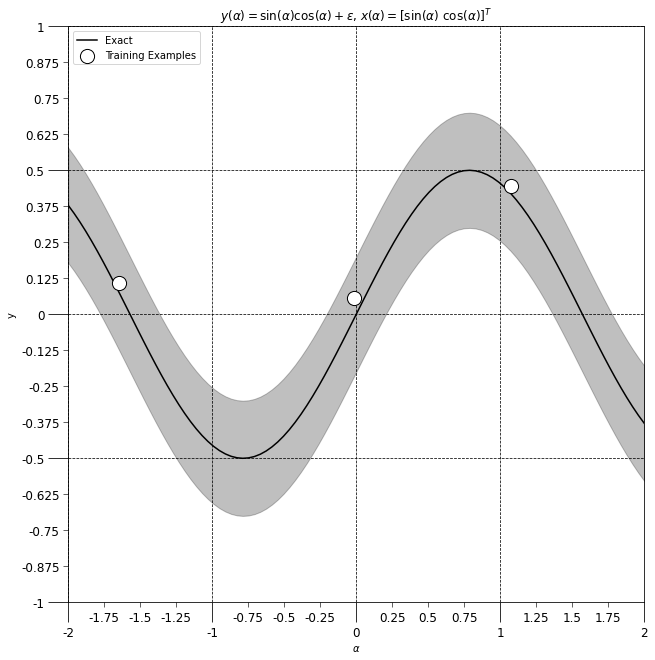

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
line, = ax.plot(alpha, Y, color='k', label='Exact')
ax.fill_between(alpha[:, 0], Y[:, 0]+error_std, Y[:, 0]-error_std, color='k', alpha=0.25)
scatter = ax.scatter(alpha_train, Y_train, s=200, marker='o', edgecolor='k',
                     color='white', label='Training Examples', zorder=3)

ax.set_title(r'$y(\alpha)=\sin(\alpha)\cos(\alpha)+\epsilon$, $x(\alpha)=[\sin(\alpha)$ $\cos(\alpha)]^T$')
ax.set_xlim(xlim)
ax.set_ylim([-1, 1])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('y')

ax.tick_params(which='major', length=20)
ax.tick_params(which='minor', length=5)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))

ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(tick_format))
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(tick_format))
ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(tick_format))
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(tick_format))

ax.legend(handles=[line, scatter], loc='upper left')
ax.grid()
plt.show()

##### 2. Preactivations Distribution Under Non-Gaussian Initialisation

For the **Gaussian initialisation**, the preactivations distributions have Gaussian distributions in the infinite-width limit.\
This is also true for **non-Gaussian initialisation**, except for the first preactivations.

In [12]:
# network parameter
n_input = 2
n_output = 1
width = 30000
bias = True
n_hidden = 2
sigma = [1, 1]
activation = 'relu'

# list of distributions
list_dist = ['normal', 'categorical', 'uniform', 'gumbel']

# create network function for each distribution
for dist in list_dist:
    dist_w = [dist, dist]
    dist_b = [dist, 'normal']
    globals()['f_{}'.format(dist)] = simple_nn(n_input=n_input,
                                               n_output=n_output,
                                               width=width,
                                               activation=activation,
                                               bias=bias,
                                               n_hidden=n_hidden,
                                               sigma=sigma,
                                               dist_w=dist_w,
                                               dist_b=dist_b)

# input for x=[0 1]
temp_alpha = 0
temp = create_X(torch.tensor([[temp_alpha]]))

# get the output of the preactivations (the first and the second ones)
for dist in list_dist:
    globals()['z_1_{}'.format(dist)] = layer_f(globals()['f_{}'.format(dist)], temp, 1)
    globals()['z_2_{}'.format(dist)] = layer_f(globals()['f_{}'.format(dist)], temp, 2)

# analytical NNGP kernel
K_1 = (sigma[0]**2)*(temp@temp.T)/n_input + sigma[1]**2
E_matrix, _ = calculate_E(K_1, activation)
K_2 = sigma[0]**2*E_matrix+sigma[1]**2

##### 2.1 Data Visualisation: Preactivations Distribution Under Non-Gaussian Initialisation

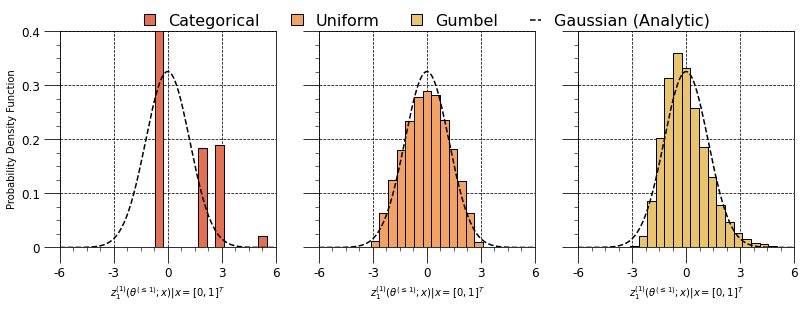

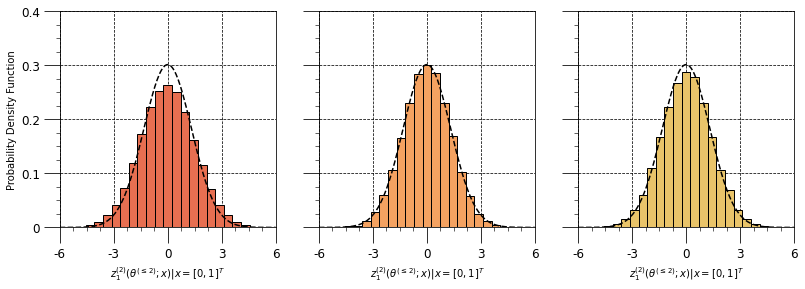

In [13]:
# number of bins in histograms
n_bin = 25

for i in range(2):
    fig, ax = plt.subplots(1, 3, figsize=a_figsize([1, 3], size=(3, 3)), sharey=True)
    combine = np.hstack([globals()['z_{}_{}'.format(i+1, dist)] for dist in list_dist])
    x_min = -6
    x_max = 6
    x = np.linspace(x_min, x_max, 201)
    K = globals()['K_{}'.format(i+1)][0, 0]
    pdf_normal = norm(loc=0, scale=np.sqrt(K)).pdf(x)
    for j, dist in enumerate(list_dist[1:]):
        ax[j].hist(globals()['z_{}_{}'.format(i+1, dist)][0],
                   n_bin,
                   range=(x_min, x_max),
                   alpha=1,
                   edgecolor='k',
                   facecolor=color[dist],
                   density=True,
                   label='{}'.format(dist.capitalize()),
                   zorder=2)
        
        handles = [matplotlib.patches.Rectangle((0,0),0,0,color=color[dist],ec="k")]
        
        line, = ax[j].plot(x, pdf_normal, color='k', linewidth=1.5, linestyle='--', label=r'$\mathcal{N}\left(0, %.3g\right)$' % K, zorder=3)
        
        
        ax[j].set_xlim([x_min, x_max])
        ax[j].set_ylim([0, 0.4])
        ax[j].set_xlabel(r'$z^{(%i)}_1(\theta^{(\leq %i)};x)|x=\left[0, 1\right]^T$' % (int(i+1), int(i+1)))
        
        ax[j].tick_params(which='major', length=16)
        ax[j].tick_params(which='minor', length=4)
        
        ax[j].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3))
        ax[j].xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
        ax[j].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.1))
        ax[j].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))

        ax[j].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(tick_format))
        ax[j].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(tick_format))
        
        ax[j].grid(zorder=-2)
        
    ax[0].set_ylabel('Probability Density Function')
    if i!=1:
        handles = [matplotlib.patches.Rectangle((0,0),0,0,color=color[dist],ec="k") for dist in list_dist[1:]]
        labels = ['{}'.format(dist.capitalize()) for dist in list_dist[1:]]
        fig.legend(handles=handles+[line], labels=labels+['Gaussian (Analytic)'], loc='upper center', ncol=4, frameon=False, fontsize=16, bbox_to_anchor=(0.5, 1.15), handlelength=0.7)
        
    plt.show()

**The first and second preactivations element distributions are compared at initialisation between Gaussian and non-Gaussian distributions**. The estimated distributions are obtained from an experiment of two hidden layers neural networks with $n_1=n_2=30000$, $\sigma_w=\sigma_b=1$, and activation function $\phi(x)=\text{ReLU}(x)$. The distributions $\mu_W$, $\mu_b$, $\mu^{(2)}$, and $\mu^{(3)}$ are initialised with Gumbel, Uniform, or Categorical distributions.
The black dashed lines indicate the analytic distributions in the infinite width limit for comparison with the Gaussian initialisation, where $z_1^{(1)}\sim\mathcal{N}(0, 1.5)$ and $z_1^{(2)}\sim\mathcal{N}(0, 1.75)$.

##### 3. Prediction and Training Dynamics for Gradient Descent, NTK, and NNGP

In [14]:
# network parameter
n_input = 2
n_output = 1
width = 1024
bias = True
n_hidden = 2
sigma = [1, 0.05]
activation = 'erf'
lr = 0.25
reg = 0

# list of distributions
list_dist = ['normal', 'categorical', 'uniform', 'gumbel']

# list of iteration to be observed
t_list = [0, 10, 75, 400]

# number of sample for empirical distribution
sample = 100

##### 3.1 Network Initialisation and Empirical Training Dynamics

In [15]:
# create network function for each distribution
for dist in list_dist:
    dist_w = [dist, dist]
    dist_b = [dist, 'normal']
    globals()['f_{}'.format(dist)] = simple_nn(n_input=n_input,
                                               n_output=n_output,
                                               width=width,
                                               activation=activation,
                                               bias=bias,
                                               n_hidden=n_hidden,
                                               sigma=sigma,
                                               dist_w=dist_w,
                                               dist_b=dist_b)
    
    globals()['f_{}_data'.format(dist)] = torch.zeros(len(t_list), len(X), sample)

# train the network function for each distribution with gradient descent to obtain the training dynamics.
for i in range(sample):
    prev = 0
    for idx, t in enumerate(t_list):  
        for dist in list_dist:
            train_f(f=globals()['f_{}'.format(dist)], 
                    loss_f=loss_mse,
                    X_train=X_train,
                    Y_train=Y_train,
                    t=t-prev,
                    lr=lr)
        
            globals()['f_{}_data'.format(dist)][idx, :, i] = globals()['f_{}'.format(dist)](X).reshape(-1).detach()
        prev = t
    for dist in list_dist:
        globals()['f_{}'.format(dist)].apply(weight_reset)

##### 3.2 Data Visualisation: NTK, NNGP, and Gradient Descent

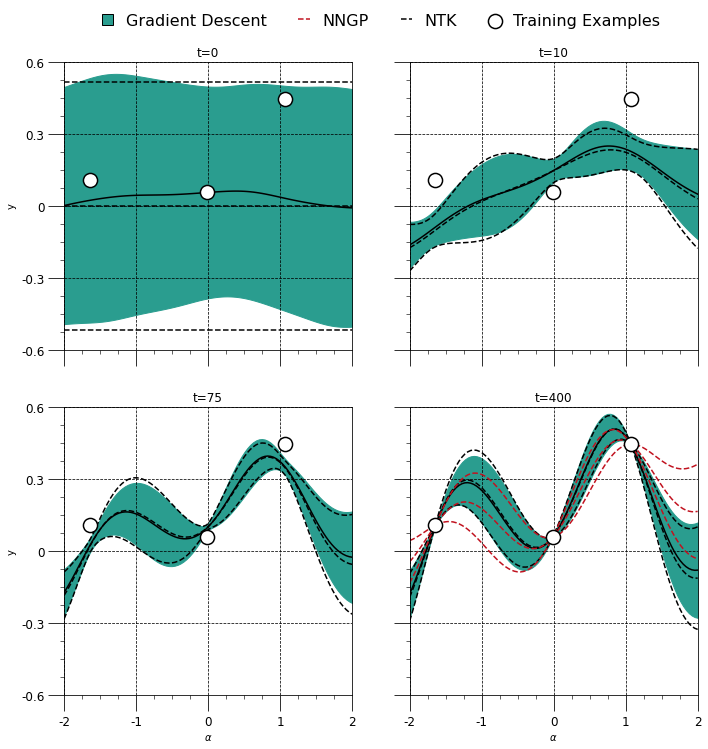

In [16]:
fig, ax = plt.subplots(2, 2, figsize=a_figsize([2, 2], size=(4, 4)), sharey=True, sharex=True)

for i, (t, axis) in enumerate(zip(t_list, ax.reshape(-1))):
    K, theta = calculate_kernel(f_normal, X, X_train)
    nngp, ntk = predict_Y(K=K,
                          theta=theta,
                          Y_train=Y_train,
                          t=t,
                          lr=lr,
                          reg=reg)
    
    std = f_normal_data[i].std(axis=1)
    mean = f_normal_data[i].mean(axis=1)
    
    scatter = axis.scatter(alpha_train, Y_train, s=200, marker='o', linewidth=1.5, edgecolor='k', color='white', label='Training Examples', zorder=3)
    axis.plot(alpha, mean, color='k', linewidth=1.5)
    gd = axis.fill_between(alpha[:, 0], mean+std, mean-std, color=color['normal'], alpha=1, label='Gradient Descent')
    axis.plot(alpha, ntk[0], color='k', linestyle='--', linewidth=1.5)
    ntk_pred, = axis.plot(alpha[:, 0], ntk[0]+ntk[1], color='k', linewidth=1.5, linestyle='--', label='NTK')
    axis.plot(alpha[:, 0], ntk[0]-ntk[1], color='k', linewidth=1.5, linestyle='--')
    
    axis.set_xlim(xlim)
    axis.set_ylim([-0.6, 0.6])
    axis.set_title('t={}'.format(t))

    axis.tick_params(which='major', length=16)
    axis.tick_params(which='minor', length=4)

    axis.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    axis.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
    axis.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.3))
    axis.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
    
    axis.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(tick_format))
    axis.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(tick_format))

    axis.grid()
    
ax[0][0].set_ylabel('y')
ax[1][0].set_ylabel('y')
ax[1][0].set_xlabel(r'$\alpha$')
ax[1][1].set_xlabel(r'$\alpha$')

ax[1][1].plot(alpha, nngp[0], color=color['nngp'], linestyle='--', linewidth=1.5)
nngp_, = ax[1][1].plot(alpha[:, 0], nngp[0]+nngp[1],  color=color['nngp'], linestyle='--', linewidth=1.5, label='NNGP')
ax[1][1].plot(alpha[:, 0], nngp[0]-nngp[1],  color=color['nngp'], linestyle='--', linewidth=1.5)

handles = [matplotlib.patches.Rectangle((0,0),0,0,color=color['normal'],ec="k")]
labels = ['Gradient Descent', 'NNGP', 'NTK','Training Examples']
fig.legend(handles=handles+[nngp_, ntk_pred, scatter], labels=labels, loc='upper center', ncol=4, frameon=False, fontsize=16, bbox_to_anchor=(0.5, 1.1), handlelength=0.7)

plt.show()

**Comparison of predictions between NTK, NNGP, and gradient descent.** The predictions are obtained from an experiment of two hidden layers neural networks with input $x=\begin{bmatrix}\sin\alpha&\cos\alpha\end{bmatrix}^T$, $\sigma_W=1$, $\sigma_b=0.05$, and activation function $\phi(x)=\text{erf}(x)$. The distributions $\mu_W$, $\mu_b$, $\mu^{(2)}$, and $\mu^{(3)}$ are initialised with Gaussian distributions. The NTK and gradient descent predictions are based on the customised MSE loss function with $\eta=0.25$. The prediction of gradient descent training is estimated by using $100$ random initialisation in finite-width networks with $n_1=n_2=1024$ and represented by the coloured green area with a solid black line as the mean of prediction. In contrast, the dashed lines indicate the predictions of NTK (black) and NNGP (red) in the infinite width limit.

##### 3.3 Data Visualisation: Comparison for non-Gaussian Initialisation with Gaussian NTK

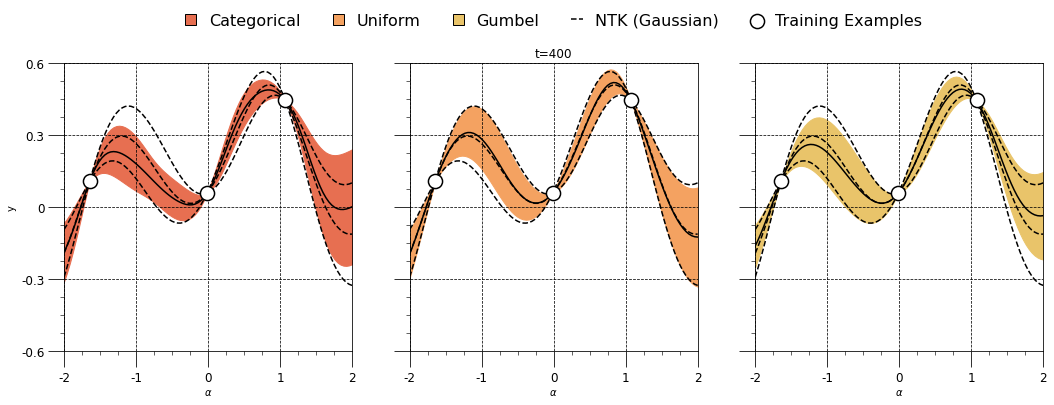

In [17]:
fig, ax = plt.subplots(1, 3, figsize=a_figsize([1, 3], size=(4, 4)), sharey=True)

for j, dist in enumerate(list_dist[1:]):
    std = globals()['f_{}_data'.format(dist)][-1].std(axis=1)
    mean = globals()['f_{}_data'.format(dist)][-1].mean(axis=1)

    ax[j].plot(alpha, mean, color='k', linewidth=1.5)
    gd = ax[j].fill_between(alpha[:, 0], mean+std, mean-std, color=color[dist], alpha=1, label=dist.capitalize())
    
    ax[j].plot(alpha, ntk[0], color='k', linestyle='--', linewidth=1.5)
    normal, = ax[j].plot(alpha[:, 0], ntk[0]+ntk[1], color='k', linewidth=1.5, linestyle='--', label='NTK Normal')
    ax[j].plot(alpha[:, 0], ntk[0]-ntk[1], color='k', linewidth=1.5, linestyle='--')

    scatter = ax[j].scatter(alpha_train, Y_train, s=200, marker='o', linewidth=1.5, edgecolor='k', color='white', label='Training Examples', zorder=3)
    
    ax[j].set_xlim(xlim)
    ax[j].set_ylim([-0.6, 0.6])
    ax[j].set_xlabel(r'$\alpha$')


    ax[j].tick_params(which='major', length=16)
    ax[j].tick_params(which='minor', length=4)

    ax[j].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax[j].xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
    ax[j].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.3))
    ax[j].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))

    ax[j].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(tick_format))
    ax[j].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(tick_format))

    ax[j].grid(zorder=-2)
    
handles = [matplotlib.patches.Rectangle((0,0),0,0,color=color[dist],ec="k") for dist in list_dist[1:]]
labels = ['{}'.format(dist.capitalize()) for dist in list_dist[1:]]
fig.legend(handles=handles+[normal, scatter], labels=labels+['NTK (Gaussian)', 'Training Examples'], loc='upper center', ncol=5, frameon=False, fontsize=16, bbox_to_anchor=(0.5, 1.225), handlelength=0.7)


ax[0].set_ylabel('y')
ax[1].set_title('t={}'.format(t))
plt.show()

**Discrepancy between networks with non-Gaussian initialisation and Gaussian NTK prediction.** The coloured areas represent one standard deviation from the mean of prediction, which is illustrated by the solid black lines. The dashed lines indicate the analytic prediction in the infinite width limit obtained from discrete-case NTK prediction.

##### 3.4 Data Visualisation: Comparison for non-Gaussian Initialisations with Their Corresponding NTK

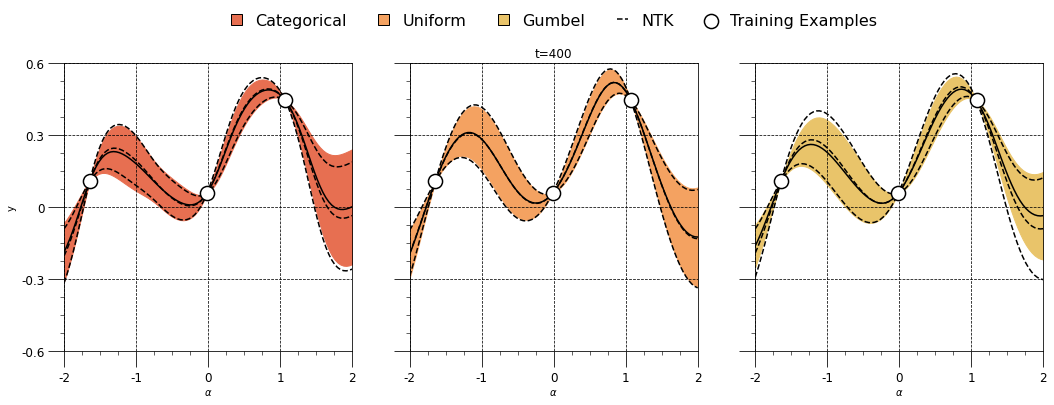

In [18]:
fig, ax = plt.subplots(1, 3, figsize=a_figsize([1, 3], size=(4, 4)), sharey=True)

for j, dist in enumerate(list_dist[1:]):
    
    K, theta = calculate_kernel(globals()['f_{}'.format(dist)], X, X_train)
    nngp, ntk = predict_Y(K=K,
                          theta=theta,
                          Y_train=Y_train,
                          t=t,
                          lr=lr,
                          reg=reg)
    
    std = globals()['f_{}_data'.format(dist)][-1].std(axis=1)
    mean = globals()['f_{}_data'.format(dist)][-1].mean(axis=1)

    ax[j].plot(alpha, mean, color='k', linewidth=1.5)
    gd = ax[j].fill_between(alpha[:, 0], mean+std, mean-std, color=color[dist], alpha=1, label=dist.capitalize())
    
    ax[j].plot(alpha, ntk[0], color='k', linestyle='--', linewidth=1.5)
    normal, = ax[j].plot(alpha[:, 0], ntk[0]+ntk[1], color='k', linewidth=1.5, linestyle='--', label='NTK')
    ax[j].plot(alpha[:, 0], ntk[0]-ntk[1], color='k', linewidth=1.5, linestyle='--')

    scatter = ax[j].scatter(alpha_train, Y_train, s=200, marker='o', linewidth=1.5, edgecolor='k', color='white', label='Training Examples', zorder=3)
    
    ax[j].set_xlim(xlim)
    ax[j].set_ylim([-0.6, 0.6])
    ax[j].set_xlabel(r'$\alpha$')

    ax[j].tick_params(which='major', length=16)
    ax[j].tick_params(which='minor', length=4)

    ax[j].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax[j].xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
    ax[j].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.3))
    ax[j].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))

    ax[j].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(tick_format))
    ax[j].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(tick_format))

    ax[j].grid(zorder=-2)
    
handles = [matplotlib.patches.Rectangle((0,0),0,0,color=color[dist],ec="k") for dist in list_dist[1:]]
labels = ['{}'.format(dist.capitalize()) for dist in list_dist[1:]]
fig.legend(handles=handles+[normal, scatter], labels=labels+['NTK', 'Training Examples'], loc='upper center', ncol=5, frameon=False, fontsize=16, bbox_to_anchor=(0.5, 1.225), handlelength=0.7)


ax[0].set_ylabel('y')
ax[1].set_title('t={}'.format(t))
plt.show()

**Training dynamics of networks with non-Gaussian initialisation and their corresponding NTK predictions.** The plots illustrates the comparison after the networks converged $(t=400)$. The coloured areas represent the estimated network prediction from gradient descent training, while the coloured dashed lines indicate the analytic predictions in the infinite width limit obtained from discrete-case NTK prediction.

##### 4. Convergence of Empirical NTK 
This experiments provide the convergence of empirical NTK as the numbers of widths increase and provides the evidence that the limiting NTK **does not depend on the choice of weight distributions in the hidden layers.**

In [19]:
# network parameters
sample = 100

test_size = 10
alpha = torch.linspace(xlim[0], xlim[1], test_size).reshape(-1, 1)
X = create_X(alpha)

n_input = 2
n_output = 1
bias = True
n_hidden = 2
sigma = [1, 0.05]
activation = 'relu'

list_dist = ['normal', 'categorical', 'uniform', 'gumbel']
list_width = [2**(n+6) for n in range(5)]

##### 4.1 First Scenario: Gaussian Initialisation for the First Weight and Bias Parameters

In [20]:
f_analytical = simple_nn(n_input=n_input,
                         n_output=n_output,
                         width=1,
                         activation=activation,
                         bias=bias,
                         n_hidden=n_hidden,
                         sigma=sigma,
                         dist_w=['normal', 'normal'],
                         dist_b=['normal', 'normal'])

_, theta = calculate_kernel(f_analytical, X, X_train)


for dist in list_dist:
    globals()['{}_data_1'.format(dist)] = torch.zeros(len(list_width))
    for i, width in enumerate(list_width):
        dist_w = ['normal', dist]
        dist_b = ['normal', 'normal']
        globals()['f_{}_{}'.format(dist, width)] = simple_nn(n_input=n_input,
                                                   n_output=n_output,
                                                   width=width,
                                                   activation=activation,
                                                   bias=bias,
                                                   n_hidden=n_hidden,
                                                   sigma=sigma,
                                                   dist_w=dist_w,
                                                   dist_b=dist_b)
        temp_ntk = 0
        for _ in range(sample):
            ntk, _ = calculate_NTK(globals()['f_{}_{}'.format(dist, width)], X)
            temp_ntk += ntk/sample
            globals()['f_{}_{}'.format(dist, width)].apply(weight_reset)
            
        globals()['{}_data_1'.format(dist)][i] = torch.norm(temp_ntk-theta[1])/torch.norm(theta[1])

##### 4.2 Second Scenario: Gumbel Initialisation for the First Weight Parameters and  Uniform for the First Bias Parameters

In [21]:
f_analytical = simple_nn(n_input=n_input,
                         n_output=n_output,
                         width=1,
                         activation=activation,
                         bias=bias,
                         n_hidden=n_hidden,
                         sigma=sigma,
                         dist_w=['gumbel', 'normal'],
                         dist_b=['uniform', 'normal'])

_, theta = calculate_kernel(f_analytical, X, X_train)


for dist in list_dist:
    globals()['{}_data_2'.format(dist)] = torch.zeros(len(list_width))
    for i, width in enumerate(list_width):
        dist_w = ['gumbel', dist]
        dist_b = ['uniform', 'normal']
        globals()['f_{}_{}'.format(dist, width)] = simple_nn(n_input=n_input,
                                                   n_output=n_output,
                                                   width=width,
                                                   activation=activation,
                                                   bias=bias,
                                                   n_hidden=n_hidden,
                                                   sigma=sigma,
                                                   dist_w=dist_w,
                                                   dist_b=dist_b)
        temp_ntk = 0
        for _ in range(sample):
            ntk, _ = calculate_NTK(globals()['f_{}_{}'.format(dist, width)], X)
            temp_ntk += ntk/sample
            globals()['f_{}_{}'.format(dist, width)].apply(weight_reset)
            
        globals()['{}_data_2'.format(dist)][i] = torch.norm(temp_ntk-theta[1])/torch.norm(theta[1])

##### 4.3 Data Visualisation: Convergence of Empirical NTK

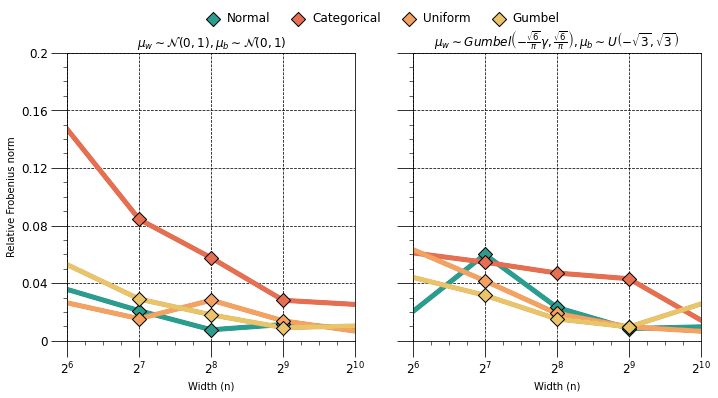

In [22]:
fig, ax = plt.subplots(1, 2, figsize=a_figsize((1, 2), size=(4, 4)), sharey=True)

for i in range(2):
    for dist in list_dist:
        ax[i].plot(np.log2(list_width), globals()['{}_data_{}'.format(dist, i+1)], color='k', linewidth=4)
        ax[i].plot(np.log2(list_width), globals()['{}_data_{}'.format(dist, i+1)], color=color[dist], linewidth=5)
        globals()['l_{}'.format(dist)] = ax[i].scatter(np.log2(list_width)[1:-1], globals()['{}_data_{}'.format(dist, i+1)][1:-1],
                                                       color=color[dist], edgecolor='k', s=100, marker='D',
                                                       label=r'%s' % (dist.capitalize()), zorder=3)


    ax[i].set_xlim([6, 10])
    ax[i].set_ylim([0, 0.2])
    ax[i].set_xlabel('Width (n)')
    

    ax[i].tick_params(which='major', length=16)
    ax[i].tick_params(which='minor', length=4)

    ax[i].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax[i].xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
    ax[i].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.04))
    ax[i].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))

    ax[i].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(power_format))
    ax[i].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(tick_format))

    ax[i].grid(zorder=-2)
    
ax[0].set_ylabel('Relative Frobenius norm')
ax[0].set_title('Scenario 1')
ax[1].set_title('Scenario 2')

handles = [globals()['l_{}'.format(dist)] for dist in list_dist]
labels = ['{}'.format(dist.capitalize()) for dist in list_dist]
fig.legend(handles=handles, labels=labels, loc='upper center', ncol=5, frameon=False, fontsize=12, bbox_to_anchor=(0.5, 1.18), handlelength=0.7)

ax[0].set_title(r'$\mu_w\sim\mathcal{N}\left(0, 1\right), \mu_b\sim\mathcal{N}\left(0, 1\right)$')
ax[1].set_title(r'$\mu_w\sim Gumbel\left(-\frac{\sqrt{6}}{\pi}\gamma, \frac{\sqrt{6}}{\pi}\right), \mu_b\sim U\left(-\sqrt{3}, \sqrt{3}\right)$')
plt.show()

**The change of relative Frobenius norm over networks with different widths.** The coloured lines are estimations of relative Frobenius norm between empirical NTK at initialisation, obtained based on an average of $100$ samples of NTK on ten equidistant points in $[-2, 2]$, and its corresponding limiting NTK. As the hidden layers weight distributions defined with different distributions with the one for analytical NTK, this plots shows that the analytical NTK does not depend on the weight distributions in the hidden layers.